# Mangrove Analysis  

## Global Mangrove Watch Data
[Global Mangrove Watch (GMW)](https://www.globalmangrovewatch.org/) is an initiative to track global mangrove extents. It uses combined ALOS PALSAR and Landsat (optical) data to form a baseline shapefile for the year 2010. More detailed information on the initiative can be found [here](http://data.unep-wcmc.org/datasets/45). To summarize, GMW shapefiles provide a general location of all mangroves in the world.

The shapefile used by this notebook is a country specific extraction from the global shapefile provided by GMW. The purpose of this notebook is to use the extracted shapefile as a baseline for classifying mangroves through NDVI thresholding. We then analyze how the mangroves change over time in our area of interest.

---
## Analysis Process
The process begins with retrieving data for a specific area in a time series. This dataset is then compressed into a mean composite for each year. From the mean composite, we then calculate the NDVI values of each pixel in each year. The dataset is then masked, and the NDVI threshold is applied for mangrove classification. The following image shows the decision tree for the classification.

![mangrove_decision_tree.png](mangrove_decision_tree.png)


After classification, we can perform a variety of analyses on the data. We can estimate the change in mangrove areas by counting all the classified pixels for each year and plotting the trend line of the count. We can also visualize the mangrove areas by plotting each classified pixel a certain color. 

## Define Options Here
Areas and times of interest are included as examples.

## Imports

In [1]:
%matplotlib inline



import datacube
import matplotlib.pyplot as plt
import warnings, sys
import numpy as np
import pandas as pd


import geopandas as gpd

from odc.algo import to_f32, from_float, xr_geomedian

from sys import path
sys.path.append('../Scripts')

from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")

from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb, map_shapefile
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

from datacube.utils import geometry
from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

## Load the Data
This method loads the data from the Open Datacube using the defined options above.

## Features
The following methods will be the features we build for our classification.


### NDVI

NDVI is used for mangrove classification within the mangrove mask.


$$ NDVI = \frac{NIR - Red}{NIR + Red} $$



### NDWI

NDWI is used for creating a better greyscale image when displaying the results.


$$ NDWI = \frac{Green - NIR}{Green + NIR} $$

## Classification
The MangroveClassifier object is used for building features and classifying mangroves based on a given threshold.

---
# Results
The following section holds the results of running the code above.

## Loading the Data

In [2]:
# dataset = load_dc_data(PLATFORM, PRODUCT, LATITUDE, LONGITUDE, YEARS)
dc = datacube.Datacube(app='Mangrove')

create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33293 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [3]:
lat = -6.1367
lon = 39.1751

# lat = -4.1
# lon = 39.5

buffer = 0.1
product_name = 'ls8_usgs_sr_scene'
query = {
   #'y': (-6.2006, -6.1099), #, (lon-buffer, lon+buffer),
   #'x': (39.4090, 39.5213), #(lat+buffer, lat-buffer),
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15),
}

output_crs = mostcommon_crs(dc=dc, product=product_name, query=query)

In [4]:
vector_file = '../Supplementary_data/Mangroves_analysis/chwaka_mangrove.shp'
attribute_col = 'FID'
#read shapefile
gdf = gpd.read_file(vector_file)


In [5]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(center=[-6.1835555555553725, 39.46066666666621], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [6]:
def cal_loaddataset(time_ds, product_name, gdf, output_crs):
    
    geom = geometry.Geometry(gdf.iloc[0].geometry.__geo_interface__,
                         geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    
    print(time_ds)

    query['time'] = time_ds
    query['geopolygon'] = geom
    # Load landsat (hide print statements)
    with HiddenPrints():
        ds_dataset = load_ard(dc=dc, 
                  products=[product_name],
                  output_crs=output_crs,
                  dask_chunks={'time': 1, 'x': 500, 'y': 500},
                  **query)
        
        sr_max_value = 10000                 # maximum value for SR in the loaded product
        scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

    #     #scale the values using the f_32 util function
        ds_scaled = to_f32(ds_dataset, scale=scale, offset=offset)
        
        
    #     #generate a geomedian
        ds_geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                          nocheck=True)   # disable checks inside library that use too much ram
     #convert SR scaling values back to original values
        ds_geomedian = from_float(ds_geomedian, 
                            dtype='float32', 
                            nodata=np.nan, 
                            scale=1/scale, 
                            offset=-offset/scale)
        ds_geomedian = ds_geomedian.compute()

        ds_geomedian = calculate_indices(ds_geomedian, index=['NDVI', 'NDWI'], collection = 'c1')
        
        mask = xr_rasterize(gdf.iloc[[0]], ds_geomedian)
        
        # Mask dataset to set pixels outside the polygon to `NaN`
        ds_dataset_masked = ds_geomedian.where(mask)

    
    return [ds_geomedian, ds_dataset_masked]

In [7]:

images_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
datacollection = {}
for images_year in images_years:
    datacollection[images_year] =  cal_loaddataset(images_year, product_name, gdf, output_crs)

datacollection

2014
2015
2016
2017
2018
2019
2020


{2014: [<xarray.Dataset>
  Dimensions:          (x: 426, y: 291)
  Coordinates:
    * y                (y) float64 -6.792e+05 -6.792e+05 ... -6.878e+05 -6.879e+05
    * x                (x) float64 5.446e+05 5.446e+05 ... 5.573e+05 5.573e+05
  Data variables:
      coastal_aerosol  (y, x) float32 186.83577 200.73238 ... 195.56384 184.70554
      blue             (y, x) float32 226.6975 232.28969 ... 247.87424 236.86113
      green            (y, x) float32 566.1641 553.56915 ... 528.5683 515.89905
      red              (y, x) float32 344.45557 342.32312 ... 386.70047 364.55777
      nir              (y, x) float32 3225.1882 3159.4934 ... 2782.6045 2793.5037
      swir1            (y, x) float32 1662.2009 1702.0328 ... 1653.8203 1620.4915
      swir2            (y, x) float32 696.4783 726.2346 ... 755.1749 732.093
      sr_aerosol       (y, x) float32 136.41531 144.84993 ... 148.3312 157.40009
      radsat_qa        (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
      NDVI 

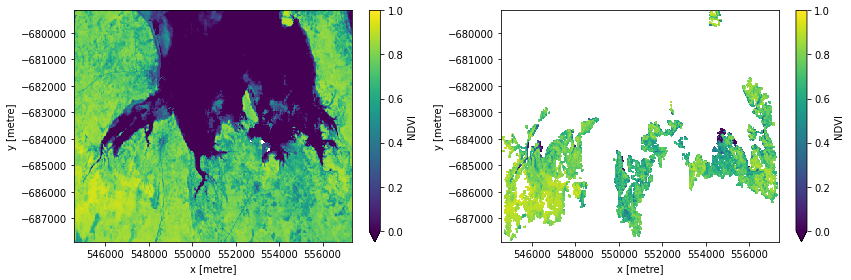

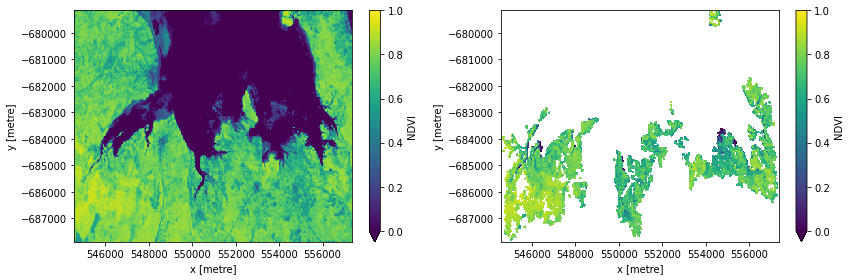

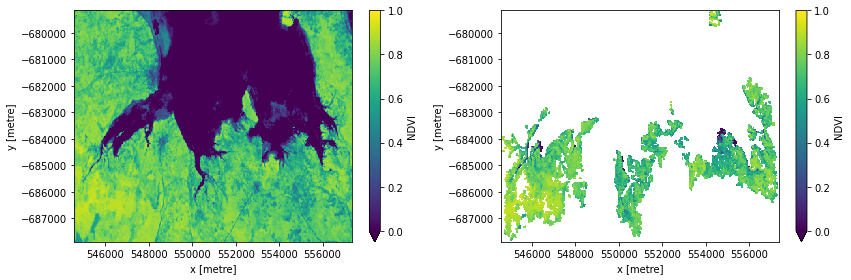

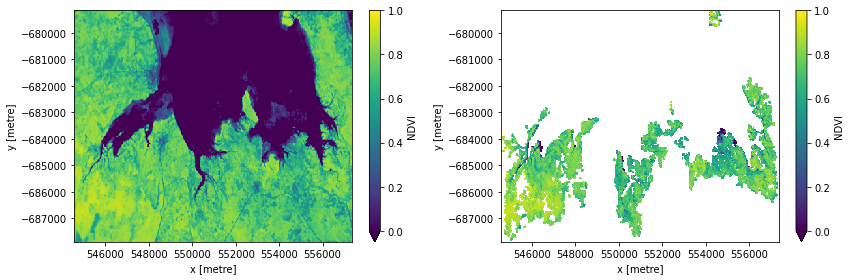

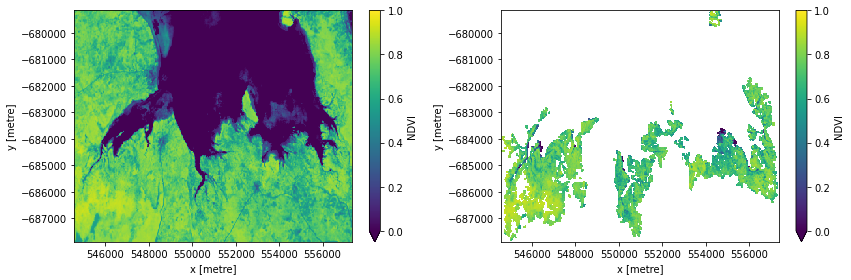

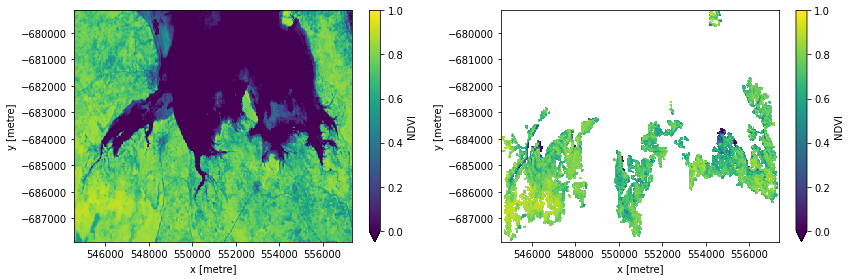

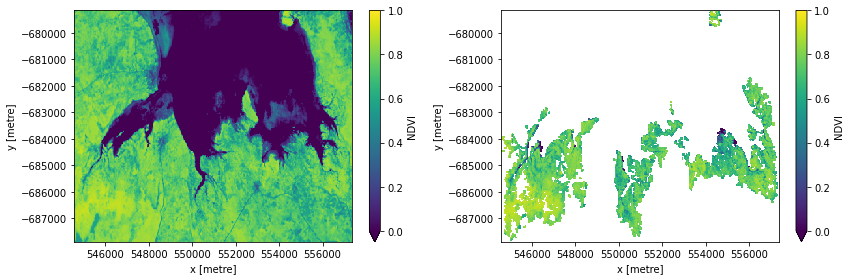

In [8]:
for images_year in images_years:
    fig = plt.figure(figsize=(12, 4))
    fig.add_subplot(1,2,1)
    datacollection[images_year][0]['NDVI'].plot(vmin=0.0, vmax=1)
    fig.add_subplot(1,2,2)
    datacollection[images_year][1]['NDVI'].plot(vmin=0.0, vmax=1)
    fig.tight_layout()
    

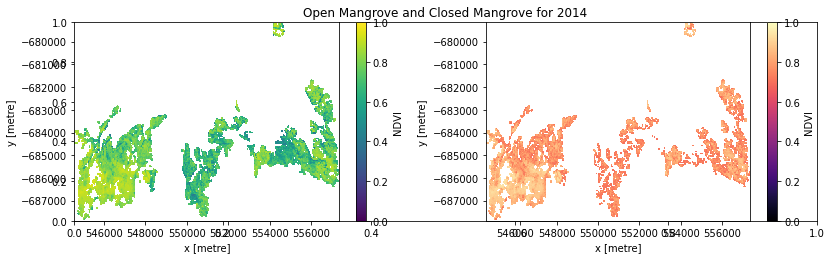

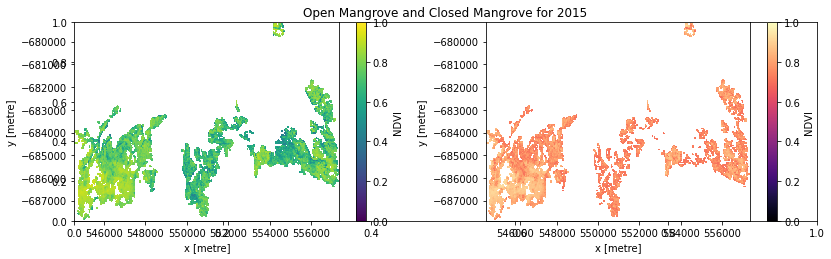

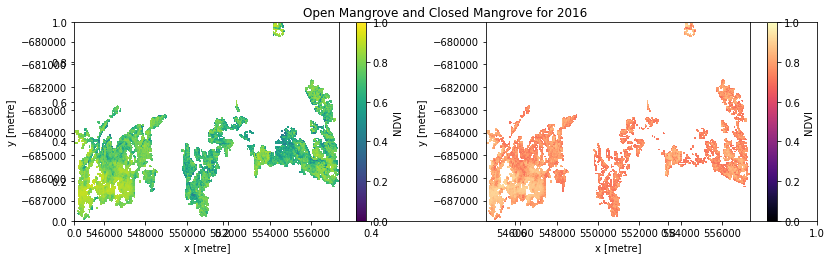

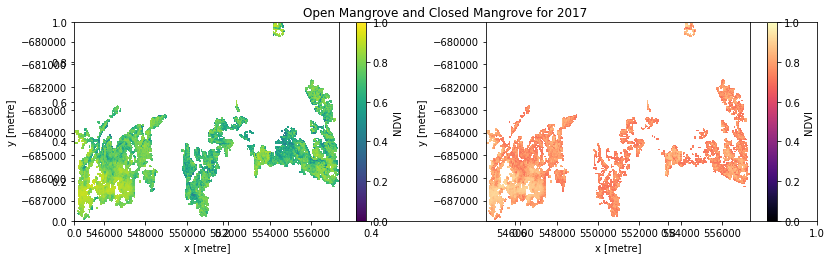

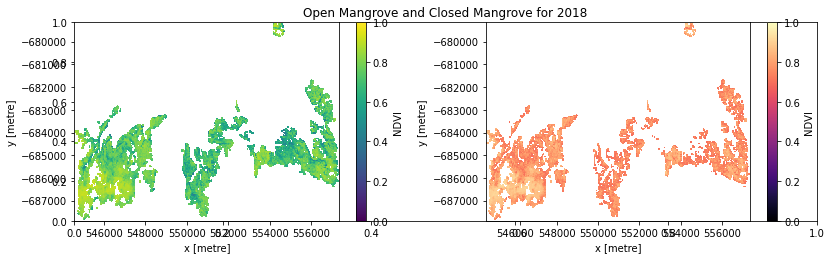

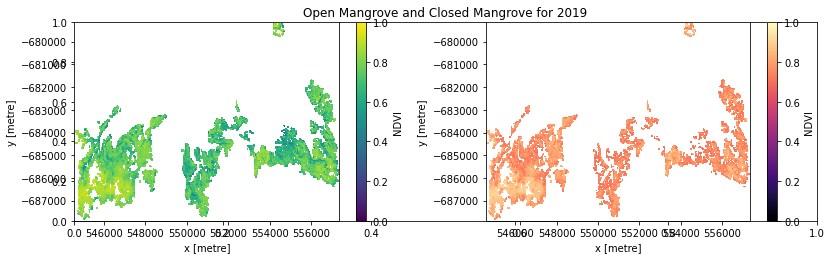

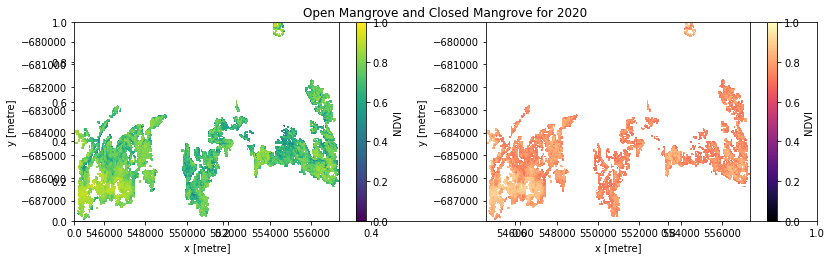

In [9]:
for images_year in images_years:
    fig = plt.figure(figsize=(12, 4))
    plt.title(f'Open Mangrove and Closed Mangrove for {str(images_year)}')
    fig.add_subplot(1,2,1)
    datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4).plot(vmin=0.0, vmax=1)
    fig.add_subplot(1,2,2)
    datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.7).plot(cmap='magma', vmin=0.0, vmax=1)
    fig.tight_layout()  

In [10]:
closed_mangrove = {}
open_mangrove = {}
for images_year in images_years:
    closed_mangrove[images_year] = (datacollection[images_year][1]['NDVI'] > 0.7).astype(int).values.sum()
    open_mangrove[images_year] = (datacollection[images_year][1]['NDVI'] > 0.4).astype(int).values.sum()

In [11]:
df = pd.DataFrame(open_mangrove, index=['All Mangrove Count']).append(pd.DataFrame(closed_mangrove,index=['Closed Mangrove Count']))
df

,2014,2015,2016,2017,2018,2019,2020
All Mangrove Count,18000,18030,18035,18029,18047,18054,18054
Closed Mangrove Count,12902,12675,12702,12821,13073,13208,13236


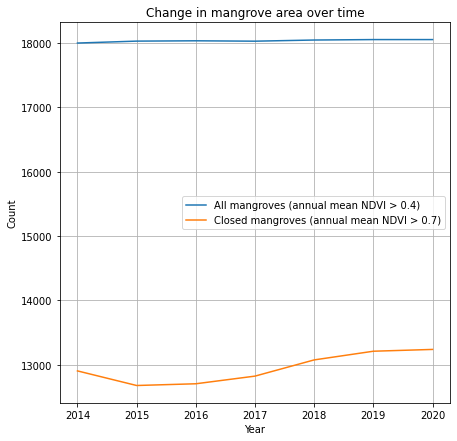

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(images_years, list(open_mangrove.values()), label='All mangroves (annual mean NDVI > {})'.format(0.4))
ax.plot(images_years, list(closed_mangrove.values()), label='Closed mangroves (annual mean NDVI > 0.7)')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Change in mangrove area over time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid()
plt.legend()

plt.show()

## Change in Mangroves
The following plot shows the change in pixel counts that correspond to a mangrove classification by means of the NDVI threshold.

## Mangroves Mapped
### All Mangroves for Chosen Year
The following image shows all the detected mangroves for the chosen year. Default selection is the last year in the selected range of years (YEARS[-1]).

Text(0.5, 1.0, 'Open Mangroves in 2020')

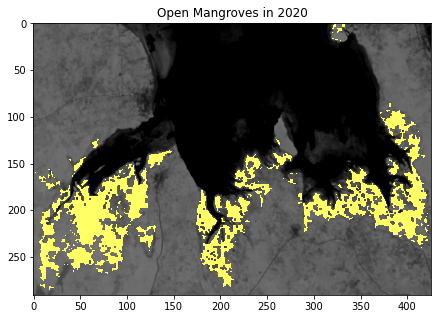

In [13]:
current_year = images_years[-1]
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[images_year][0]['NDVI'], cmap='gist_gray', vmin=0,vmax=2)
plt.imshow(datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4), cmap='summer',  vmin=0,vmax=0.5)
plt.title('Open Mangroves in ' + str(current_year))

### Closed Mangroves for Chosen Year
The following image is the same as the first, but highlights closed mangroves (with NDVI > 0.7).

* Green - Closed Mangroves
* OrRd - Other Mangroves

Text(0.5, 1.0, 'Closed Mangroves in 2020')

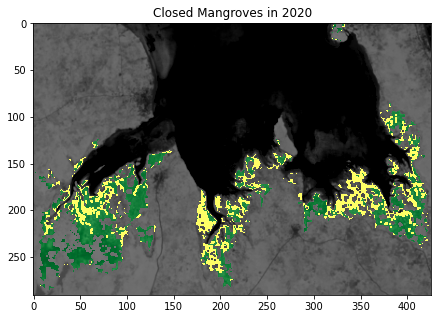

In [14]:
#Closed Mangroves
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[images_year][0]['NDVI'], cmap='gist_gray', vmin=0,vmax=2)
plt.imshow(datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4), cmap='summer',  vmin=0,vmax=0.5)
plt.imshow(datacollection[current_year][1]['NDVI'].where(datacollection[current_year][1]['NDVI'] > 0.7), cmap='Greens',  vmin=0,vmax=1)
plt.title('Closed Mangroves in ' + str(current_year))

### Change in Mangroves
The following image shows the change in mangroves between two selected years. Default selection is the oldest year and the year chosen above (YEARS[0], YEAR).

* Green - New Mangroves
* White - No Change
* Red - Loss of Mangroves

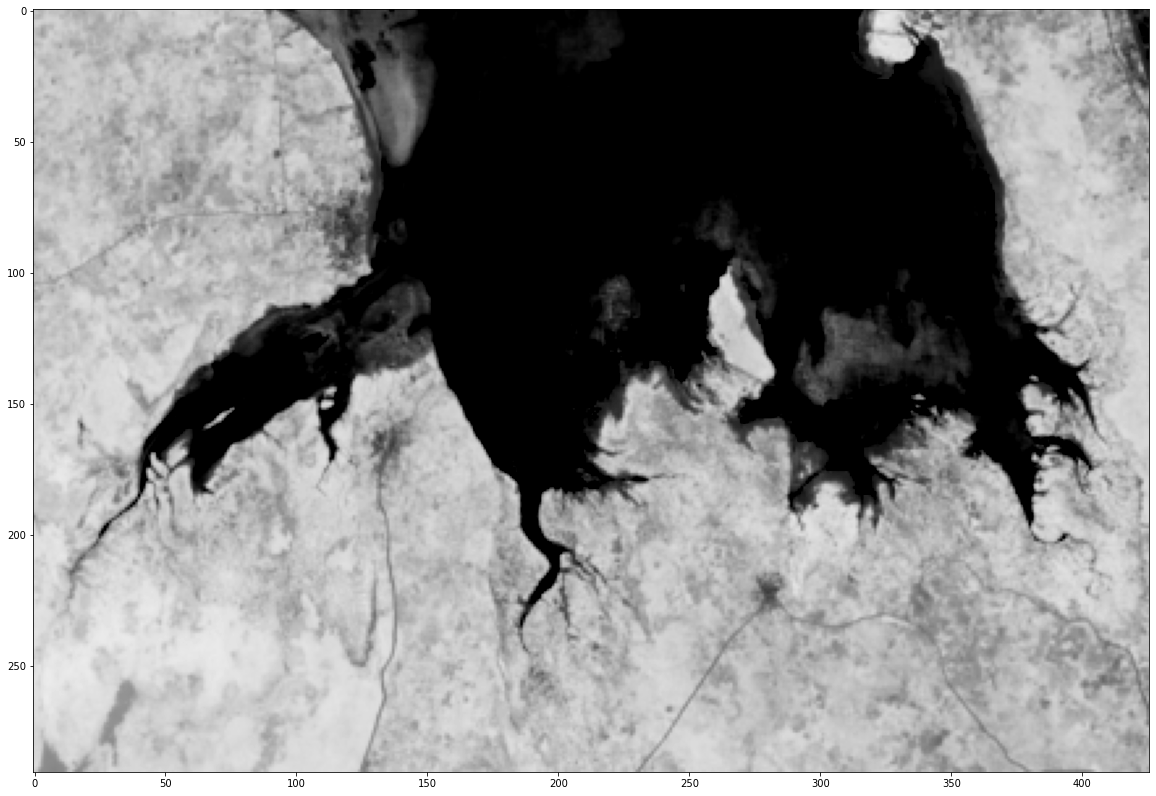

In [15]:
# # Select the year range here (ex: TIME = (2010, 2016)).
TIME = (images_years[0], current_year)

old_mangrove =  (datacollection[TIME[0]][1]['NDVI'] > 0.4).astype(int)
new_mangrove =  (datacollection[TIME[1]][1]['NDVI'] > 0.4).astype(int)

change = new_mangrove - old_mangrove
change_appeared = change.where(change==1)
change_disappeared = change.where(change==-1)
stable = change.where(change==0)

plt.figure(figsize=(20, 50),)



plt.imshow(datacollection[TIME[1]][0]['NDVI'],  cmap='gist_gray', vmin=0,vmax=1)
plt.imshow(change_appeared, cmap='Greens', vmin=0,vmax=1)
plt.imshow(change_disappeared, cmap='OrRd', vmin=-2,vmax=-1)


#### Pixel Counts

In [16]:
loss_count = (change==-1).values.sum()
gain_count = (change==1).values.sum()
stable_count = (change==0).values.sum()

counts = {
          'Loss of Mangroves': int(loss_count),
          'New Mangroves': int(gain_count),
#           'No Change': int(stable_count),
          'Delta Change': int(gain_count - loss_count)
          }

df = pd.DataFrame(counts, index=['Pixel Count'])
print('Pixel Counts of Mangrove Changes Between the Years {} and {}:'.format(TIME[0], TIME[1]))
df

Pixel Counts of Mangrove Changes Between the Years 2014 and 2020:


,Loss of Mangroves,New Mangroves,Delta Change
Pixel Count,15,69,54


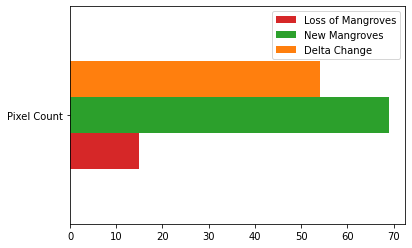

In [17]:
df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])